In [6]:
import pickle as pkl
import matplotlib.pyplot as plt
import collections

In [323]:
with open("unique_fol_rules.pkl", "rb") as file:
    data = pkl.load(file)

In [324]:
data[1]

('(γ ∨ (β → α)) ⇔ (α ∨ γ ∨ ¬β)',
 13,
 {'program_complexity': 7,
  'original_depth': 2,
  'original_complexity': 12,
  'exprs': ['γ ∨ (β → α)', 'α ∨ γ ∨ ¬β'],
  'complexity_by_step': [5, 5],
  'elimination_complexity': [1],
  'num_var': [3, 3],
  'num_ops': [2, 2]})

In [325]:
len(data)

2000000

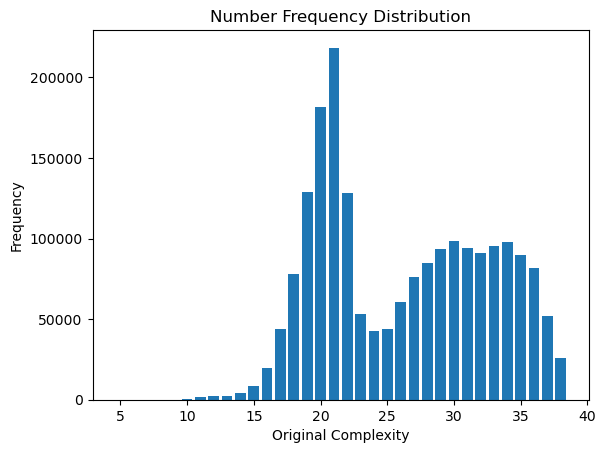

In [326]:
original_complexities = [z['original_complexity'] for x,y,z in data]
frequency = collections.Counter(original_complexities)
plt.bar(frequency.keys(), frequency.values())
plt.xlabel('Original Complexity')
plt.ylabel('Frequency')
plt.title('Number Frequency Distribution')
plt.show()

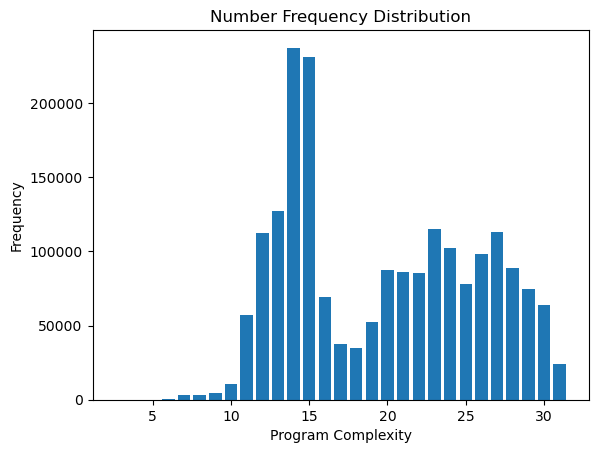

In [327]:
original_complexities = [z['program_complexity'] for x,y,z in data]
frequency = collections.Counter(original_complexities)
plt.bar(frequency.keys(), frequency.values())
plt.xlabel('Program Complexity')
plt.ylabel('Frequency')
plt.title('Number Frequency Distribution')
plt.show()

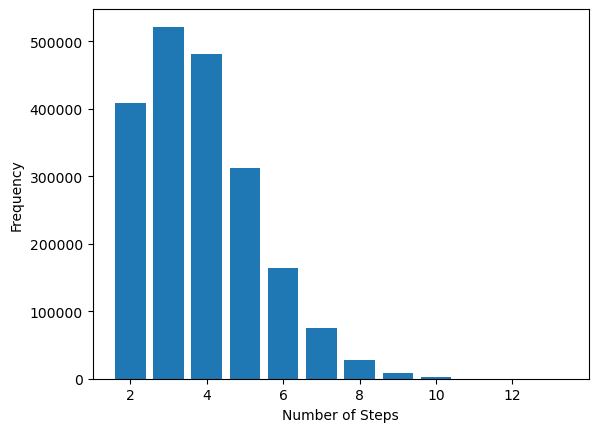

In [328]:
original_complexities = [len(z['exprs']) for x,y,z in data]
frequency = collections.Counter(original_complexities)
plt.bar(frequency.keys(), frequency.values())
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')
#plt.title('Number Frequency Distribution')
plt.show()

# Data Cleaning

In [329]:
import re

def standardize_variables(expr):
    """
    Rename variables in a logical expression to α, β, γ, ... in order of appearance.
    
    Args:
        expr (str): A string representing the logical expression.
    
    Returns:
        str: A new expression with variables renamed in order of appearance.
    """
    greek_vars = ['α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 
                  'ν', 'ξ', 'ο', 'π', 'ρ', 'σ', 'τ', 'υ', 'φ', 'χ', 'ψ', 'ω']
    
    # Find all Greek variables (assumes variables are single Greek letters in α-ω range)
    vars_found = re.findall(r"[α-ω]", expr)
    
    # Preserve order of first appearance
    seen = []
    for var in vars_found:
        if var not in seen:
            seen.append(var)
    
    # Map each unique variable to the next Greek letter
    rename_map = {var: greek_vars[i] for i, var in enumerate(seen)}
    
    # Replace variables in expression
    renamed_expr = ''.join(rename_map.get(ch, ch) for ch in expr)
    
    return renamed_expr


In [330]:
unique = set()
unique_data = []
i = 0

for x,_,z in data:
    cleaned = standardize_variables(x)
    if cleaned not in unique:
        unique.add(cleaned)
        z['rule'] = x
        z['id'] = f"{i}"
        unique_data.append(z)
        i+=1

len(unique)

1754626

In [331]:
len(test), len(train), len(dev)

(52638, 1701988, 5105)

# Test Train Split

In [332]:
import random

def split_list(data, fraction=0.2):
    # Shuffle a copy of the original list
    data_copy = data[:]
    random.shuffle(data_copy)
    
    # Compute split index
    split_idx = int(len(data_copy) * fraction)
    
    # Get the 20% subset and the remaining
    subset = data_copy[:split_idx]
    remaining = data_copy[split_idx:]
    
    return subset, remaining

In [333]:
test, train = split_list(unique_data, fraction=0.03)

In [334]:
import copy

sampled = random.sample(train, k=int(len(train) * 0.003))
dev = [copy.deepcopy(x) for x in sampled]

In [335]:
for x in dev:
    x["id"] = "dev_"+x["id"]

for x in train:
    x["id"] = "train_"+x["id"]

for x in test:
    x["id"] = "test_"+x["id"]



In [336]:
len(test), len(train), len(dev)

(52638, 1701988, 5105)

In [337]:
import json

with open("train_rules.json", "w") as f:
    json.dump(train, f, indent=2, ensure_ascii=False)

with open("dev_rules.json", "w") as f:
    json.dump(dev, f, indent=2, ensure_ascii=False)

with open("test_rules.json", "w") as f:
    json.dump(test, f, indent=2, ensure_ascii=False)

# Get true or false test data

In [338]:
tf_test = []
not_tf_test = []

for x in test:
    if "True" in x["exprs"][-1] or "False" in x["exprs"][-1]:
        tf_test.append(x)
    else:
        not_tf_test.append(x)

In [339]:
len(tf_test), len(not_tf_test)

(19048, 33590)

In [340]:
from collections import defaultdict
grouped_tests_by_expr_length = defaultdict(list)

for x in tf_test:
    k = len(x["exprs"])
    if k not in grouped_tests_by_expr_length:
        grouped_tests_by_expr_length[k] = []
    grouped_tests_by_expr_length[k].append(x)

In [341]:
len(grouped_tests_by_expr_length[2])

4196

In [342]:
count_t, count_f = 0,0

for x in grouped_tests_by_expr_length[2]:
    if "True" in x['rule']:
        count_t += 1
    else:
        count_f += 1

print("true count: {}, false count: {}".format(count_t, count_f))

true count: 3637, false count: 559


In [343]:
grouped_by_elimination_complexity = defaultdict(list)
for x in grouped_tests_by_expr_length[2]:
    key = x['elimination_complexity'][0]
    grouped_by_elimination_complexity[key].append(x)

In [344]:
sorted(grouped_by_elimination_complexity.keys())

[1, 3, 4, 5, 6, 7, 8, 9]

In [345]:
selected_data = []

for k,v in grouped_by_elimination_complexity.items():
    if k in [1,3]:
        selected_data += random.sample(v, 100)
    else:    
        selected_data += v

In [346]:
len(selected_data)

256

In [347]:
complexities = []

for x in selected_data:
    complexities.append(x["complexity_by_step"][0])

frequency = collections.Counter(complexities)
frequency

Counter({19: 28,
         13: 28,
         20: 23,
         17: 22,
         14: 20,
         18: 20,
         12: 20,
         11: 15,
         16: 14,
         15: 12,
         22: 10,
         21: 10,
         25: 7,
         23: 6,
         10: 5,
         26: 4,
         24: 4,
         9: 3,
         27: 2,
         28: 2,
         29: 1})

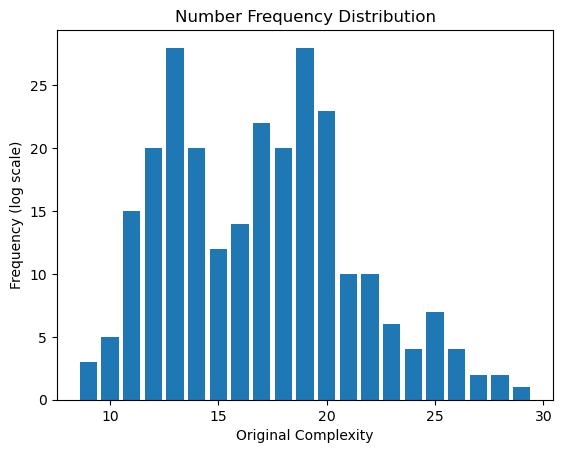

In [348]:
plt.bar(frequency.keys(), frequency.values())
#plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.xlabel('Original Complexity')
plt.ylabel('Frequency (log scale)')
plt.title('Number Frequency Distribution')
plt.show()

In [349]:
complexities = []

for x in selected_data:
    complexities.append(x["elimination_complexity"][0])

frequency = collections.Counter(complexities)

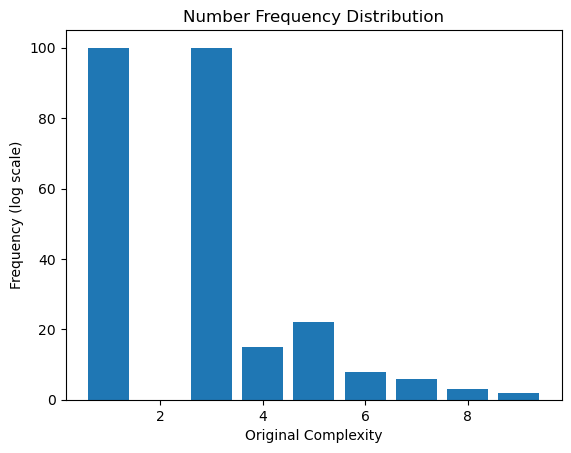

In [350]:
plt.bar(frequency.keys(), frequency.values())
#plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.xlabel('Original Complexity')
plt.ylabel('Frequency (log scale)')
plt.title('Number Frequency Distribution')
plt.show()


In [352]:
with open("tf_test_rules.json", "w") as f:
    json.dump(selected_data, f, indent=2, ensure_ascii=False)

# in the train set

In [353]:
tf_test = []
not_tf_test = []

for x in train:
    if "True" in x["exprs"][-1] or "False" in x["exprs"][-1]:
        tf_test.append(x)
    else:
        not_tf_test.append(x)

In [354]:
len(tf_test), len(not_tf_test)

(612300, 1089688)

In [355]:
from collections import defaultdict
grouped_tests_by_expr_length = defaultdict(list)

for x in tf_test:
    k = len(x["exprs"])
    if k not in grouped_tests_by_expr_length:
        grouped_tests_by_expr_length[k] = []
    grouped_tests_by_expr_length[k].append(x)

In [356]:
len(grouped_tests_by_expr_length[2])

131986

In [357]:
count_t, count_f = 0,0

for x in grouped_tests_by_expr_length[2]:
    if "True" in x['rule']:
        count_t += 1
    else:
        count_f += 1

print("true count: {}, false count: {}".format(count_t, count_f))

true count: 114378, false count: 17608


In [358]:
grouped_by_elimination_complexity = defaultdict(list)
for x in grouped_tests_by_expr_length[2]:
    key = x['elimination_complexity'][0]
    grouped_by_elimination_complexity[key].append(x)

In [364]:
selected_data = []

for k,v in grouped_by_elimination_complexity.items():
    if len(v)>100:
        selected_data += random.sample(v, 100)
    else:    
        selected_data += v

In [363]:
for k,v in grouped_by_elimination_complexity.items():
    print(k, len(v))

1 122200
3 7981
9 36
4 634
6 375
5 583
8 60
7 103
10 11
12 2
11 1


In [365]:
len(selected_data)

710

In [366]:
with open("tf_train_rules.json", "w") as f:
    json.dump(selected_data, f, indent=2, ensure_ascii=False)

In [57]:
def save_list_to_pickle(data_list, filename):
    """
    Saves a list to a pickle file.
    
    Parameters:
    data_list (list): The list to be saved.
    filename (str): The name of the pickle file.
    """
    with open(filename, 'wb') as file:
        pkl.dump(data_list, file)

In [24]:
save_list_to_pickle(deduped_data, 'processed_unique_rules.pkl')